# Task 1 - Sentiment Model

## Data Extraction - code from data_loader_demo.ipynb

In [26]:
%load_ext autoreload
%autoreload 2

import warnings
import joblib

# Exploration
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Engineering
import numpy as np
import pandas as pd

import nltk
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from scipy.sparse import hstack

# Modelling
import params as p
import functions as f

from imblearn.over_sampling import RandomOverSampler

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, classification_report

import optuna

import sys
sys.path.append('..')

import data_loader

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jamesstephenson/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jamesstephenson/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jamesstephenson/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### Settings

In [3]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

### Import Data

In [4]:
(
    train_sentences, test_sentences, val_sentences, train_labels, test_labels, val_labels,
    ) = data_loader.import_task1_data()

Reusing dataset financial_phrasebank (/Users/jamesstephenson/.cache/huggingface/datasets/financial_phrasebank/sentences_50agree/1.0.0/a6d468761d4e0c8ae215c77367e1092bead39deb08fbf4bffd7c0a6991febbf0)
100%|██████████| 1/1 [00:00<00:00, 172.95it/s]

The dataset is a dictionary with two splits: 

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 4846
    })
})
How many instances in the train dataset? 

3876

What does one instance look like? 

In his current position , Manty has worked since 1996 .
instances in the validation dataset 

969

instances in the test dataset 

970


## Data Exploration

In [5]:
train = pd.DataFrame({'sentences' : train_sentences, 'labels' : train_labels})

### Very Brief Response Analysis

Should only need to do this for train due to random split. So would expect to see the same structure for test and val

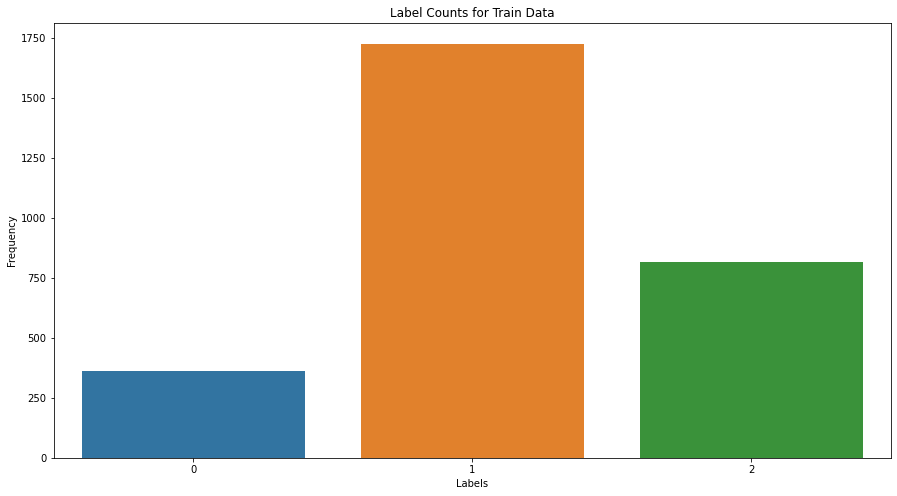

In [6]:
# Make figure and axis
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (15, 8))

# Create plot of label counts
ax = sns.countplot(data = train, x = 'labels').set(title = 'Label Counts for Train Data')

# Edit plot to show correct labels
plt.xlabel("Labels")
plt.ylabel("Frequency")
plt.xticks(rotation = 0)

# Show Plot
plt.show()

There is a slight imbalance in labels, but nothing that should be an issue. If we find this is an issue later on, we can perform some over or under sampling.

# Featuring Engineering

### Sentence Processing

In [7]:
# Remove some stopwords to capture negation in n-grams if possible
stop_words = nltk.corpus.stopwords.words('english')
stop_words.remove('no')
stop_words.remove('not')
stop_words.remove('but')

# Define a function to get the position tag for each word - this helps to lemmatize words correctly with context
def get_wordnet_pos(word: str):
        '''Map POS tag to first character lemmatize() accepts
        
        Arguments:
            word (str): word to find wordnet position tag for'''
        
        # Get first letter of pos_tag
        tag = nltk.pos_tag([word])[0][1][0].upper()

        # Translate letter into wordnet position tag
        tag_dict = {
            'J': nltk.corpus.wordnet.ADJ,
            'N': nltk.corpus.wordnet.NOUN,
            'V': nltk.corpus.wordnet.VERB,
            'R': nltk.corpus.wordnet.ADV
            }

        return tag_dict.get(tag, nltk.corpus.wordnet.NOUN)

def text_preprocess(sentence: str):
    '''Preprocesses the inputted sentence and does the following: sets to lowercase,
    removes unwanted characters, lemmatizes and removes stopwords
    
    Arguments:
        sentence (str): sentence to be processed

    Returns:
        sentence (str): processed sentence'''

    # Set to lower case
    sentence = str(sentence).lower()
    
    # Remove non-letter characters and replace the abbreviation 'mn' for million
    sentence = re.sub(r'[^a-zA-Z\s]',r'', sentence)
    sentence = re.sub('mn', 'million', sentence)

    # Load up a WordNet Lemmatizer
    wnl = nltk.stem.WordNetLemmatizer()

    # Wordnet lemmatizer with position tagging to give context
    sentence = ' '.join([wnl.lemmatize(word, get_wordnet_pos(word)) for word in nltk.word_tokenize(sentence)])
    
    # Removal of Stopwords
    sentence = ' '.join([word for word in nltk.word_tokenize(sentence) if word not in stop_words])
    
    return sentence

# Turn the above function into a vectorized function to work on columns for sentences
vect_text_preprocess = np.vectorize(text_preprocess)

### Create Modelling Features

In [8]:
def get_lexicon_scores(cvec: CountVectorizer):

    sia = SentimentIntensityAnalyzer()

    vocab = cvec.vocabulary_

    lex_pos_scores = np.zeros((1, len(vocab)))
    lex_neg_scores = np.zeros((1, len(vocab)))

    for i, word in enumerate(vocab):
        if word in sia.lexicon and sia.lexicon[word] > 0:
            lex_pos_scores[0, i] = 1
        elif word in sia.lexicon and sia.lexicon[word] < 0:
            lex_neg_scores[0, i] = 1

    return lex_pos_scores, lex_neg_scores


def create_lexicon_feature(data, cvec):

    lex_pos_scores, lex_neg_scores = get_lexicon_scores(cvec)

    lex_pos = np.sum(data.multiply(lex_pos_scores), axis=1)
    lex_neg = np.sum(data.multiply(lex_neg_scores), axis=1)

    return np.concatenate((lex_pos, lex_neg), axis = 1)

def generate_data_columns(cvec: CountVectorizer):

    opt = cvec.get_feature_names()
    opt.append('negative_lexicon')
    opt.append('positive_lexicon')

    return opt


def create_modelling_feature(train, test, val):

    cvec = CountVectorizer(ngram_range = (1, 2))

    cvec_train = cvec.fit_transform(train)
    cvec_test = cvec.transform(test)
    cvec_val = cvec.transform(val)

    tfidf = TfidfTransformer()

    tfidf_train = tfidf.fit_transform(cvec_train)
    tfidf_test = tfidf.transform(cvec_test)
    tfidf_val = tfidf.transform(cvec_val)

    lex_train = create_lexicon_feature(cvec_train, cvec)
    lex_test = create_lexicon_feature(cvec_test, cvec)
    lex_val = create_lexicon_feature(cvec_val, cvec)

    X_train = hstack((tfidf_train, lex_train))
    X_test = hstack((tfidf_test, lex_test))
    X_val = hstack((tfidf_val, lex_val))

    Xcols = generate_data_columns(cvec)

    print(X_train.shape, X_test.shape, X_val.shape)

    return X_train, X_test, X_val, Xcols

In [9]:
# Clean train, test and validation sentences using the vectorized text_processor
clean_train_sentences = vect_text_preprocess(train_sentences)
clean_test_sentences = vect_text_preprocess(test_sentences)
clean_val_sentences = vect_text_preprocess(val_sentences)

# Create 
X_train, X_test, X_val, Xcols = create_modelling_feature(
    clean_train_sentences,
    clean_test_sentences,
    clean_val_sentences
    )

(2907, 29387) (970, 29387) (969, 29387)


## Modelling

We will be using the ROC AUC Score as our evaluation metric since is provides a good balance between True Negative and False Positives in one score. This is preferred to Accuracy due to our imbalance and Precision and Recall since we require a balance of the both to get a good model. Since ROC score uses predicted probabilities as its input, we don't have to tune the threshold.

### Baseline Model - Linear Regression and a TF-IDF Vectorizer

We are using a Logistic Regressor since it is a robust model across a wide state space so should be able to deal with our sentences effectively. We will be using a TF-IDF Vectorizer to vectorize our sentences before modelling.

In [17]:
# Make a dictionary for each train, test and validation to make fitting and evaluation cleaner.
train_data = {'X' : X_train.tocsr(), 'y' : train_labels}
test_data = {'X' : X_test.tocsr(), 'y' : test_labels}
val_data = {'X' : X_val.tocsr(), 'y' : val_labels}

datasets = {
    'train' : train_data,
    'test' : test_data,
    'val' : val_data
    }

In [18]:
baseline_lr = LogisticRegression()

baseline_lr.fit(**train_data)

f.evaluate_model_on_ttv(baseline_lr, datasets)

--- Model Metrics for Datasets --- 


,ROC,Accuracy,Precision,Recall
Train,0.993692,0.863433,0.913949,0.741468
Test,0.859479,0.710309,0.685781,0.535305


### Model Tuning - Logistic Regression

In [19]:
# sampler = optuna.samplers.TPESampler(seed=p.RANDOM_STATE)
# study = optuna.create_study(sampler = sampler, direction = 'maximize', study_name = 'T1_HyperParam_CV')


# oscv_base_params = {
#     'random_state' : p.RANDOM_STATE,
#     'solver' : 'saga',
#     'penalty' : 'l1',
#     'max_iter' : 100000
# }

# oscv_params = {
#     'C': optuna.distributions.LogUniformDistribution(1e-4, 1),
# }

# oscv = optuna.integration.OptunaSearchCV(
#     study = study,
#     estimator = LogisticRegression(**oscv_base_params),
#     param_distributions = oscv_params,
#     cv = 10,
#     n_jobs = -1,
#     n_trials = 100,
#     random_state = p.RANDOM_STATE,
#     refit = True,
#     scoring = 'roc_auc_ovr',
#     verbose = 1
# )

# oscv.fit(**train_data)

[I 2022-04-17 17:51:14,177] A new study created in memory with name: T1_HyperParam_CV
/var/folders/2f/cwgmhyzx4fn5cwp5j_dpmsd00000gn/T/ipykernel_85602/3449259455.py:16: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  oscv = optuna.integration.OptunaSearchCV(
[I 2022-04-17 17:51:14,197] Searching the best hyperparameters using 2907 samples...
[I 2022-04-17 17:51:14,880] Trial 4 finished with value: 0.5 and parameters: {'C': 0.002609658652589337}. Best is trial 4 with value: 0.5.
[I 2022-04-17 17:51:14,994] Trial 5 finished with value: 0.5 and parameters: {'C': 0.0018307710409670535}. Best is trial 4 with value: 0.5.
[I 2022-04-17 17:51:15,026] Trial 0 finished with value: 0.5 and parameters: {'C': 0.005151460396953906}. Best is trial 4 with value: 0.5.
[I 2022-04-17 17:51:15,088] Trial 7 finished with value: 0.5 and parameters: {'C': 0.0006995813429418889}. Best is trial 4 with value: 0.5.
[I 2022-04-17 17:51:15,185

OptunaSearchCV(cv=10,
               estimator=LogisticRegression(max_iter=100000, penalty='l1',
                                            random_state=73, solver='saga'),
               n_jobs=-1, n_trials=100,
               param_distributions={'C': LogUniformDistribution(high=1.0, low=0.0001)},
               random_state=73, scoring='roc_auc_ovr',
               study=<optuna.study.study.Study object at 0x17fb97910>,
               verbose=1)

In [20]:
# f.evaluate_model_on_ttv(oscv.best_estimator_, datasets)

--- Model Metrics for Datasets --- 


,ROC,Accuracy,Precision,Recall
Train,0.856585,0.744410,0.789578,0.600893
Test,0.822775,0.720619,0.686031,0.585152


In [21]:
# # Create tuned LR model
# lr_tuned = oscv.best_estimator_

In [22]:
# oscv.best_params_

{'C': 0.9995260908318777}

In [27]:
joblib.dump(oscv.best_estimator_, 'xgb_model.pkl')

['xgb_model.pkl']

#### Overall Evaluation

In [28]:
best_model = joblib.load('xgb_model.pkl')

In [23]:
# Calculate model metrics for each dataset
model_metrics = {
    'Train' : f.evaluate_model(best_model, **train_data),
    'Test' : f.evaluate_model(best_model, **test_data),
    'Validation' : f.evaluate_model(best_model, **val_data)
}

# Display metrics in a dataframe
pd.DataFrame(model_metrics).T

,ROC,Accuracy,Precision,Recall
Train,0.856585,0.744410,0.789578,0.600893
Test,0.822775,0.720619,0.686031,0.585152
Validation,0.841010,0.730650,0.715350,0.593966


### Confusion Matrix

In [24]:
print(classification_report(y_true = val_labels, y_pred = best_model.predict(X_val)))

              precision    recall  f1-score   support

           0       0.69      0.40      0.51       121
           1       0.74      0.94      0.82       576
           2       0.72      0.44      0.55       272

    accuracy                           0.73       969
   macro avg       0.72      0.59      0.63       969
weighted avg       0.73      0.73      0.71       969



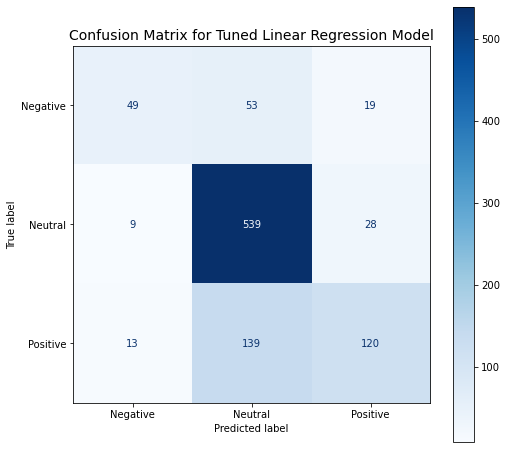

In [25]:
def create_confusion_matrix(model, model_name: str):
    """Calculates and displays a confusion matrix for model

    Args:
        model: model to evaluate
        model_name (str): name of model
    """

    # Create figure and axis to display plot
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))

    # Calculates confusion matrix
    plot_confusion_matrix(model, X_val, val_labels, cmap = "Blues", ax = ax, display_labels = ['Negative', "Neutral", 'Positive'])

    # Sets title for plot
    plt.title(f"Confusion Matrix for {model_name} Model", fontdict= {'fontsize' : 14})

    plt.savefig('Confusion Matrix.png')

    # Shows plot
    plt.show()

# Calculate confusion matrix for Tuned LR model
create_confusion_matrix(best_model, "Tuned Linear Regression")

### Feature Importances

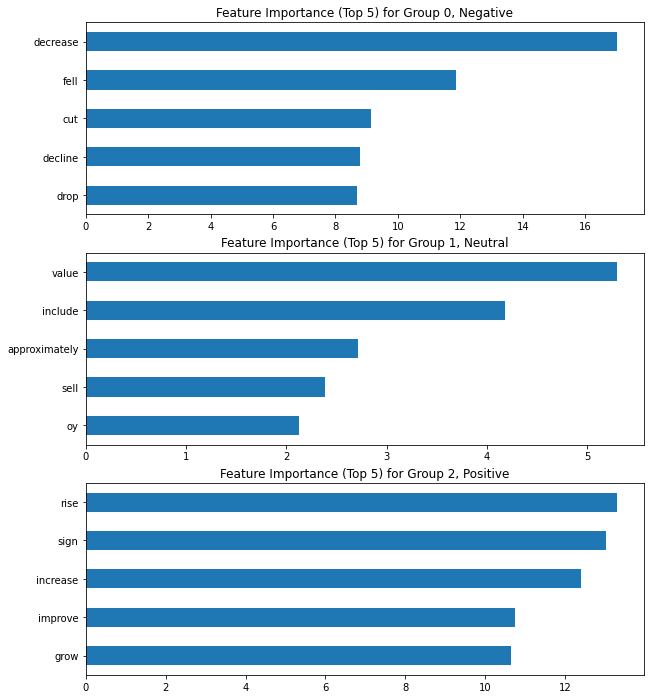

In [23]:
def plot_feature_importance(model, model_name: str):
    """Plots feature importances for the specified class label

    Args:
        model: model we want importances for
        model_name (str): name of model
        class_label (int): class we want to analyse (one of 0, 1 or 2)
    """

    class_dict = {0 : 'Negative', 1 : 'Neutral', 2 : 'Positive'}

    # Create figure and axis to display plot
    fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize=(10, 12))

    for idx, cl in enumerate([0, 1, 2]):
        # Retrive feature coefficients from model for class label
        coefs = model.coef_[cl]

        # Plot coefficients as a horizontal bar plot
        pd.Series(coefs, index=Xcols).nlargest(5).sort_values(ascending=True).plot(
            kind="barh", ax=ax[idx], title=f"Feature Importance (Top 5) for Group {cl}, {class_dict[cl]}"
        )

    # Show plot
    plt.show()


# Call function for Tuned LR model
plot_feature_importance(best_model, "Tuned Logistic Regression")
